## 6.3 랭그래프 실습

### 6.3.2 [실습] 코드 어시스트 챗봇

In [1]:
%%capture --no-stderr
! pip install langchain_community tiktoken langchain-openai chromadb langchain langgraph python-dotenv

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from dotenv import load_dotenv

# .env 파일에서 환경 변수 로드
load_dotenv("/content/.env")

True

In [4]:
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader

# 크롤링할 URL을 지정합니다.
url = "https://python.langchain.com/v0.2/docs/concepts/#langchain-expression-language-lcel"
# 해당 페이지를 재귀적으로 크롤링합니다
loader = RecursiveUrlLoader(
    url=url, max_depth=20, extractor=lambda x: Soup(x, "html.parser").text
)

# 지정된 URL에서 문서들을 크롤링하고, 이를 'docs' 변수에 저장합니다.
docs = loader.load()

# 크롤링된 문서들을 'source' 메타데이터를 기준으로 정렬합니다.
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))

# 모든 문서의 내용을 하나의 문자열로 연결합니다.
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)

In [5]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI

# LLM이 LCEL 전문가로서 사용자의 질문에 답변하도록 지시하는 프롬프트를 정의합니다
system = """
당신은 LCEL(LangChain expression language) 전문가인 코딩 어시스턴트입니다.
다음은 필요한 LCEL 문서 전문입니다:
-------
{context}
-------
위에 제공된 문서를 기반으로 사용자 질문에 답변하세요.
제공하는 코드는 실행 가능해야 하며, 필요한 모든 import 문과 변수들이 정의되어 있어야 합니다.
답변을 다음과 같은 구조로 작성하세요:
1. prefix : 문제와 접근 방식에 대한 설명
2. imports : 코드 블록 import 문
3. code : import 문을 제외한 코드 블록
4. description : 질문에 대한 코드 스키마

다음은 사용자 질문입니다:
"""

# 시스템 메시지와 사용자의 질문을 포함한 템플릿을 만듭니다
code_gen_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("placeholder", "{messages}"),
    ]
)


# 코드 출력을 구조화하기 위한 데이터 모델을 정의합니다.
class code(BaseModel):
    prefix: str = Field(description="문제와 접근 방식에 대한 설명")
    imports: str = Field(description="코드 블록 import 문")
    code: str = Field(description="import 문을 제외한 코드 블록")
    description: str = Field(description="질문에 대한 코드 스키마")


# 코드 생성을 위한 LLM 을 정의합니다.
llm = ChatOpenAI(temperature=0, model="gpt-4o-mini")

# 프롬프트, 구조화된 LLM 출력을 결합하여 RAG 체인을 만듭니다.
code_gen_chain = code_gen_prompt | llm.with_structured_output(code)

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.11/dist-packages/langchain_openai/chat_models/base.py:1624: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  

In [6]:
question = "LCEL로 RAG 체인 어떻게 만들어?"
solution = code_gen_chain.invoke(
    {"context": concatenated_content, "messages": [("user", question)]}
)
print(solution)

prefix='이 코드는 LangChain Expression Language (LCEL)를 사용하여 Retrieval-Augmented Generation (RAG) 체인을 만드는 방법을 보여줍니다. RAG 체인은 LLM이 외부 데이터 소스에서 정보를 검색하고 이를 기반으로 응답을 생성하는 구조입니다.' imports='from langchain_core.prompts import ChatPromptTemplate\nfrom langchain_openai import ChatOpenAI\nfrom langchain_core.output_parsers import StrOutputParser\nfrom langchain_core.retrievers import MyRetriever\n\n# RAG 체인 구성 요소 정의\nretriever = MyRetriever()  # 사용자 정의 리트리버 인스턴스 생성\nmodel = ChatOpenAI(model="gpt-4")  # OpenAI 모델 인스턴스 생성\nprompt_template = ChatPromptTemplate.from_template("{context}\\n{question}")  # 프롬프트 템플릿 정의\n\n# RAG 체인 구성\nchain = prompt_template | retriever | model | StrOutputParser()' code='# RAG 체인 실행\nquestion = "What is the capital of France?"\n\n# 리트리버를 사용하여 관련 문서 검색\ncontext = retriever.retrieve(question)\n\n# 체인 실행\nresponse = chain.invoke({"context": context, "question": question})\nprint(response)' description='이 코드는 LCEL을 사용하여 RAG 체인을 구성하는 방법을 보여줍니다. 사용자는 질문을 입력하면 리트리버가 관련 문서를 검색하고, 

In [7]:
from typing import List, TypedDict


class GraphState(TypedDict):
    error: str
    messages: List
    generation: str
    iterations: int

In [8]:
def generate(state: GraphState):
    """
    코드를 생성합니다

    Args:
        state (dict): 현재 그래프의 상태

    Returns:
        state (dict): 생성한 코드가 업데이트된 상태
    """

    print("---코드 생성---")

    messages = state["messages"]
    iterations = state["iterations"]
    error = state.get("error", "no")

    if error == "yes":
        messages += [
            (
                "user",
                "다시 시도해보세요. 출력 결과를 prefix, imports, code block으로 구조화하기 위해 코드 도구를 호출하세요:",
            )
        ]

    code_solution = code_gen_chain.invoke(
        {"context": concatenated_content, "messages": messages}
    )
    messages += [
        (
            "assistant",
            f"{code_solution.prefix} \n Imports: {code_solution.imports} \n Code: {code_solution.code}",
        )
    ]

    iterations = iterations + 1
    return {"generation": code_solution, "messages": messages, "iterations": iterations}


def code_check(state: GraphState):
    """
    코드 검사

    Args:
        state (dict): 현재 그래프의 상태

    Returns:
        state (dict): 에러 여부가 업데이트된 상태
    """

    print("---코드 검사---")

    messages = state["messages"]
    code_solution = state["generation"]
    iterations = state["iterations"]

    imports = code_solution.imports
    code = code_solution.code

    try:
        exec(imports)
    except Exception as e:
        print("---import 체크: 실패---")
        error_message = [("user", f"당신의 코드는 import 테스트를 실패했습니다: {e}")]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }

    try:
        exec(imports + "\n" + code)
    except Exception as e:
        print("---code block 체크: 실패---")
        error_message = [("user", f"당신의 코드는 실행 테스트를 실패했습니다: {e}")]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }

    print("---에러 없음---")
    return {
        "generation": code_solution,
        "messages": messages,
        "iterations": iterations,
        "error": "no",
    }


def reflect(state: GraphState):
    """
    에러 반영

    Args:
        state (dict): 현재 그래프 상태

    Returns:
        state (dict): 생성된 코드가 추가된 상태
    """

    print("---코드 솔루션 생성---")

    messages = state["messages"]
    iterations = state["iterations"]
    code_solution = state["generation"]

    reflections = code_gen_chain.invoke(
        {"context": concatenated_content, "messages": messages}
    )
    messages += [("assistant", f"여기 오류를 반영한 코드입니다: {reflections}")]
    return {"generation": code_solution, "messages": messages, "iterations": iterations}


In [9]:
flag = "do not reflect"


def decide_to_finish(state: GraphState):
    """
    종료 여부를 결정합니다.

    Args:
        state (dict): 현재 그래프의 상태

    Returns:
        str: 다음에 호출할 노드
    """
    error = state["error"]
    iterations = state["iterations"]

    if error == "no" or iterations == 3:
        print("---종료---")
        return "end"
    else:
        print("---재시도---")
        if flag is True:
            return "reflect"
        else:
            return "generate"


In [10]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# 노드 정의
workflow.add_node("generate", generate)
workflow.add_node("check_code", code_check)
workflow.add_node("reflect", reflect)

# 그래프 정의
workflow.add_edge(START, "generate")
workflow.add_edge("generate", "check_code")
workflow.add_conditional_edges(
    "check_code",
    decide_to_finish,
    {
        "end": END,
        "reflect": "reflect",
        "generate": "generate",
    },
)
workflow.add_edge("reflect", "generate")

# 그래프 컴파일
app = workflow.compile()

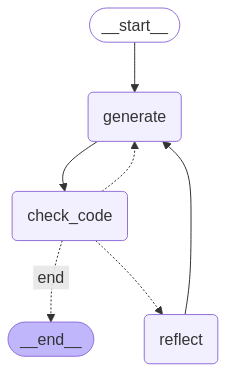

In [11]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [12]:
question = "문자열을 runnable 객체에 직접 전달하고, 이를 사용하여 내 프롬프트에 필요한 입력을 구성하려면 어떻게 해야 하나요?"
app.invoke({"messages": [("user", question)], "iterations": 0})

---코드 생성---
---코드 검사---
---code block 체크: 실패---
---재시도---
---코드 생성---
---코드 검사---
---code block 체크: 실패---
---재시도---
---코드 생성---
---코드 검사---
---code block 체크: 실패---
---종료---


{'error': 'yes',
 'messages': [('user',
   '문자열을 runnable 객체에 직접 전달하고, 이를 사용하여 내 프롬프트에 필요한 입력을 구성하려면 어떻게 해야 하나요?'),
  ('assistant',
   '이 코드는 문자열을 Runnable 객체에 직접 전달하고, 이를 사용하여 프롬프트에 필요한 입력을 구성하는 방법을 보여줍니다. Runnable 객체는 입력을 받아 처리할 수 있는 표준 인터페이스를 제공합니다. \n Imports: from langchain_core.prompts import PromptTemplate\nfrom langchain_core.runnables import Runnable \n Code: # 문자열을 Runnable 객체에 전달하는 예제\n\n# 프롬프트 템플릿 정의\nprompt_template = PromptTemplate.from_template("Tell me a joke about {topic}")\n\n# Runnable 객체 생성\nrunnable = Runnable(lambda inputs: prompt_template.invoke(inputs))\n\n# 문자열 입력\ninput_string = {\'topic\': \'cats\'}\n\n# Runnable 객체 호출\noutput = runnable.invoke(input_string)\n\n# 결과 출력\nprint(output)'),
  ('user', '당신의 코드는 실행 테스트를 실패했습니다: Runnable() takes no arguments'),
  ('user',
   '다시 시도해보세요. 출력 결과를 prefix, imports, code block으로 구조화하기 위해 코드 도구를 호출하세요:'),
  ('assistant',
   '이 코드는 문자열을 Runnable 객체에 직접 전달하고, 이를 사용하여 프롬프트에 필요한 입력을 구성하는 방법을 보여줍니다. Runnable 객체는 입력을 받아 처리할 수 있는